In [2]:
from abc import ABC, abstractmethod
import numpy as np
import random

# Strategies

In [3]:
class Strategy(ABC):
    @abstractmethod
    def move(self, own_history, opponent_history):
        pass

In [4]:
# C unless opponent's last move was D
class TitForTatStrategy(Strategy):
    def move(self, own_history, opponent_history):
        if not opponent_history or opponent_history[-1] == "C":
            move = "C"
        else:
            move = "D"

        return move

In [5]:
# Naively faithful player (always chooses C)
class AlwaysCooperateStrategy(Strategy):
    def move(self, own_history, opponent_history):
        move = "C"
        return move

In [6]:
# Always chooses D
class AlwaysDefectStrategy(Strategy):
    def move(self, own_history, opponent_history):
        move = "D"
        return move

In [7]:
# Alternating choices between C and D
class AlternatingStrategy(Strategy):
    def move(self, own_history, opponent_history):
        if not own_history or own_history[-1] == "D":
            move = "C"
        else:
            move = "D"
        return move

In [8]:
# Special class of adaptive players who weighs the expected score for each decision (over opponent's history)
class AdaptiveStrategy(Strategy):
    def move(self, own_history, opponent_history):
        # percentage of cooperative decisions in opponent's history
        if len(opponent_history) != 0:
            opponent_fidelity = opponent_history.count("C") / len(opponent_history)
        else:
            opponent_fidelity = 1  # assume the best in people
        reward_C = opponent_fidelity * 3 + (1 - opponent_fidelity) * 0
        reward_D = opponent_fidelity * 5 + (1 - opponent_fidelity) * 1

        if reward_C > reward_D:
            move = "C"
        else:
            move = "D"
        return move

In [9]:
# class Grudger(Player):
#     def __init__(self):
#         super().__init__()
#         self.has_been_betrayed = False

#     def move(self, opponent_history):
#         # If the Grudger has never encountered a defect or if the opponent's history is empty
#         if not self.has_been_betrayed or not opponent_history:
#             if 'D' in opponent_history:
#                 self.has_been_betrayed = True
#                 move = 'D'
#             else:
#                 move = 'C'
#         else:
#             # Defect indefinitely after encountering a betrayal
#             move = 'D'
#         self.update_history(move)
#         return move

# Strategy Switchers

In [10]:
class StrategySwitcher(ABC):
    @abstractmethod
    def check(self, agent, opponent_history):
        pass

In [11]:
class NOPSwitcher(StrategySwitcher):
    def check(self, agent, opponent_history):
        return False, None

In [12]:
class CooperateUntilDefection(StrategySwitcher):
    def check(self, agent, opponent_history):
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]

        if (
            agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy"
            and opponent_history
            and opponent_history[-1] == "D"
        ):
            return True, AlwaysDefectStrategy()

        return False, None

# Player

In [13]:
# Generic class for any Player (next block we shall define inherited classes with specific strategies)
class Player:
    def __init__(self, strategy, strategy_switcher):
        self.history = []
        self.strategy = strategy
        self.strategy_switcher = strategy_switcher

    def play(self, opponent_history):
        should_switch_strategy, next_strategy = self.strategy_switcher.check(
            self, opponent_history
        )
        if should_switch_strategy:
            self.switch_strategy(next_strategy)

        decision = self.strategy.move(self.history, opponent_history)
        self.update_history(decision)
        return decision

    def update_history(self, own_move):
        self.history.append(own_move)

    def latest_move(self):
        return self.history[-1]

    def reset(self):
        self.history = []

    def switch_strategy(self, new_strategy):
        self.strategy = new_strategy

# Helper Functions

In [14]:
# Define a typical Prisoner's Dilemma payoff matrix
PAYOFF_MATRIX = {
    'C': {'C': (3, 3), 'D': (0, 5)},
    'D': {'C': (5, 0), 'D': (1, 1)}
}

In [15]:
# Function that lets player1 and player2 play N rounds
def play_game(player1, player2, N):
    for _ in range(N):
        player1.play(player2.history)  # Player1 decides based on player2's history
        player2.play(player1.history)  # Player2 decides based on player1's history

    return player1.history, player2.history

In [16]:
# Helper function to compute scores given histories of two players
def compute_scores(history1, history2, payoff_matrix):
    scores1 = []
    scores2 = []

    for move1, move2 in zip(history1, history2):
        score1, score2 = payoff_matrix[move1][move2]
        scores1.append(score1)
        scores2.append(score2)

    total_score1 = sum(scores1)
    total_score2 = sum(scores2)

    return scores1, scores2, total_score1, total_score2

In [17]:
# Function that picks a (different) opponent at random on the lattice
def pick_random_opponent(i, j, N):
    while True:
        opponent_i = random.randint(0, N - 1)
        opponent_j = random.randint(0, N - 1)
        if (opponent_i, opponent_j) != (
            i,
            j,
        ):  # Ensure the opponent is not the same player
            return opponent_i, opponent_j

# Simulation

In [18]:
# Instantiate players on a lattice
N = 100  # Lattice size
lattice = [[None for _ in range(N)] for _ in range(N)]

# sprinkle in some special players (adaptive)
m = 20
special_agents = np.zeros(N * N)
special_agents[:m] = 1
np.random.shuffle(special_agents)
special_agents = special_agents.reshape(N, N)

for i in range(N):
    for j in range(N):
        if special_agents[i][j] == 0:
            lattice[i][j] = Player(AlternatingStrategy(), NOPSwitcher())
        else:
            lattice[i][j] = Player(AdaptiveStrategy(), NOPSwitcher())

# Let all players each play with (N^2-1) others at random
game_num = 2
for i in range(N):
    for j in range(N):
        opponent_i, opponent_j = pick_random_opponent(i, j, N)
        player = lattice[i][j]
        opponent = lattice[opponent_i][opponent_j]
        play_game(player, opponent, game_num)


# After all games are played, record all history lists into array: data
data = np.zeros((game_num * (N**2 - 1), N, N), dtype=int)  # Initialize data array
for j in range(N):
    for k in range(N):
        player = lattice[j][k]
        # print(len(player.history))
        decisions = [1 if move == "C" else -1 for move in player.history]
        data[: len(decisions), j, k] = decisions

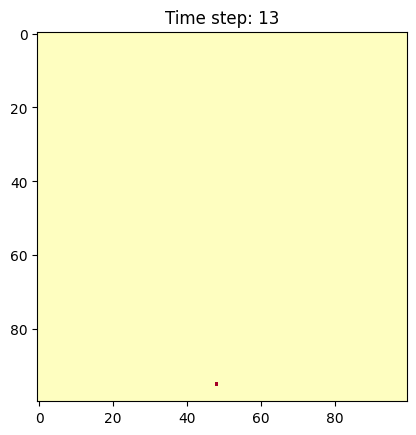

In [19]:
# Block of code for visualization (export a .gif for now)

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


sums_along_first_axis = np.sum(np.abs(data), axis=(1, 2))
last_nonzero_slice = np.max(np.nonzero(sums_along_first_axis))
data_truncate = data[: last_nonzero_slice + 1]

fig, ax = plt.subplots()
plt.axis("off")

# Setting up the colormap - you can choose your own colors
cmap = plt.get_cmap("RdYlBu")
norm = plt.Normalize(-1, 1)


def update(frame):
    ax.clear()
    ax.imshow(data_truncate[frame], cmap=cmap, norm=norm)
    ax.set_title(f"Time step: {frame}")


ani = FuncAnimation(fig, update, frames=data_truncate.shape[0], repeat=True)
# plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))

# Save as GIF
ani.save("animation.gif", writer=PillowWriter(fps=1))

# Show the animation
plt.show()

In [20]:
# Function to count number of players of each strategy
def count_strategies(agent_list, strategy_classes):
    strategy_counts = {name: 0 for name in [cls.__name__ for cls in strategy_classes]}

    for agent in agent_list:
        for strategy_class in strategy_classes:
            if isinstance(agent.strategy, strategy_class):
                strategy_counts[strategy_class.__name__] += 1
                break

    return strategy_counts


# Flatten the lattice and count:
strategy_classes = Strategy.__subclasses__()
agents = [item for sublist in lattice for item in sublist]
strategy_distribution = count_strategies(agents, strategy_classes)
print(strategy_distribution)

{'TitForTatStrategy': 0, 'AlwaysCooperateStrategy': 0, 'AlwaysDefectStrategy': 0, 'AlternatingStrategy': 9980, 'AdaptiveStrategy': 20}


In [21]:
# Statistics, only applicable after define switching (with conditions)

# Network Generator

In [67]:
import random


class Network:
    def __init__(self, N, M, Ntype="Lattice", density=0, spread=0):
        assert Ntype in ["Graph", "Lattice", "CLattice"]
        self.dim = (N, M)
        self.sz = N * M
        self.type = Ntype
        self.density = density
        self.spread = spread

    def generate(self):
        self.l = [[0 for _ in range(self.sz)] for _ in range(self.sz)]

        if self.type == "Graph":
            e = int((self.sz * self.sz - self.sz) * self.density / 2)
            assert e > 0

            random.seed(int(self.sz * e / 4))

            cnt = 0
            while cnt < e:
                edj = random.randrange(0, self.sz * self.sz)
                u, v = edj % self.sz, edj // self.sz
                if u == v or self.l[u][v] > 0:
                    continue
                self.l[u][v] = self.l[v][u] = 1
                cnt = cnt + 1

        elif self.type == "Lattice":
            for i in range(0, self.dim[0]):
                for j in range(0, self.dim[1]):
                    if i > 0:
                        self.l[i * self.dim[1] + j][(i - 1) * self.dim[1] + j] = 1
                    if i < self.dim[0] - 1:
                        self.l[i * self.dim[1] + j][(i + 1) * self.dim[1] + j] = 1
                    if j > 0:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j - 1] = 1
                    if j < self.dim[1] - 1:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j + 1] = 1

        elif self.type == "CLattice":
            for i in range(0, self.dim[0]):
                for j in range(0, self.dim[1]):
                    if i > 0:
                        self.l[i * self.dim[1] + j][(i - 1) * self.dim[1] + j] = 1
                    if i < self.dim[0] - 1:
                        self.l[i * self.dim[1] + j][(i + 1) * self.dim[1] + j] = 1
                    if j > 0:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j - 1] = 1
                    if j < self.dim[1] - 1:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j + 1] = 1

            e = int((self.sz * self.sz - self.sz) * self.density / 2)
            assert e > 0

            random.seed(int(self.sz * e / 4))

            cnt = 0
            while cnt < e:
                edj1 = random.randrange(0, self.sz)
                u1, v1 = edj1 // self.dim[1], edj1 % self.dim[1]
                u2, v2 = round(random.gauss(u1, self.spread)), round(random.gauss(v1, self.spread))
                if (
                    (u1 == u2 and v1 == v2)
                    or u2 < 0
                    or u2 >= self.dim[0]
                    or v2 < 0
                    or v2 >= self.dim[1]
                ):
                    continue
                edj2 = u2 * self.dim[1] + v2
                if self.l[edj1][edj2] > 0:
                    continue
                self.l[edj1][edj2] = self.l[edj2][edj1] = 1
                cnt = cnt + 1

        self.E = 0
        for i in range(self.sz):
            for j in range(i, self.sz):
                if self.l[i][j] != 0:
                    self.E = self.E + 1
        

    def checkEdge(self, i1, j1, i2, j2):
        return (
            True if self.l[i1 * self.dim[1] + j][i2 * self.dim[1] + j2] == 1 else False
        )

    def getEdges(self, i, j):
        eList = []
        for v in range(0, self.sz):
            if self.l[i * self.dim[0] + j][v] == 1:
                eList.append((v // self.dim[1], v % self.dim[1]))

        return eList

    def stringTuple(self, u):
        return "(" + str(u // self.dim[1]) + ", " + str(u % self.dim[1]) + ")"

    def printNet(self):
        print("|V| = " + str(self.sz) + "; |E| = " + str(self.E))
        for u in range(self.sz):
            print(self.stringTuple(u) + ": ", end="")
            lst = self.getEdges(u // self.dim[1], u % self.dim[1])
            for v in lst:
                print(self.stringTuple(v[0] * self.dim[1] + v[1]) + ", ", end="")
            print()


In [68]:
net1 = Network(5, 5, "Lattice")

net1.generate()

net1.printNet()

|V| = 25; |E| = 40
(0, 0): (0, 1), (1, 0), 
(0, 1): (0, 0), (0, 2), (1, 1), 
(0, 2): (0, 1), (0, 3), (1, 2), 
(0, 3): (0, 2), (0, 4), (1, 3), 
(0, 4): (0, 3), (1, 4), 
(1, 0): (0, 0), (1, 1), (2, 0), 
(1, 1): (0, 1), (1, 0), (1, 2), (2, 1), 
(1, 2): (0, 2), (1, 1), (1, 3), (2, 2), 
(1, 3): (0, 3), (1, 2), (1, 4), (2, 3), 
(1, 4): (0, 4), (1, 3), (2, 4), 
(2, 0): (1, 0), (2, 1), (3, 0), 
(2, 1): (1, 1), (2, 0), (2, 2), (3, 1), 
(2, 2): (1, 2), (2, 1), (2, 3), (3, 2), 
(2, 3): (1, 3), (2, 2), (2, 4), (3, 3), 
(2, 4): (1, 4), (2, 3), (3, 4), 
(3, 0): (2, 0), (3, 1), (4, 0), 
(3, 1): (2, 1), (3, 0), (3, 2), (4, 1), 
(3, 2): (2, 2), (3, 1), (3, 3), (4, 2), 
(3, 3): (2, 3), (3, 2), (3, 4), (4, 3), 
(3, 4): (2, 4), (3, 3), (4, 4), 
(4, 0): (3, 0), (4, 1), 
(4, 1): (3, 1), (4, 0), (4, 2), 
(4, 2): (3, 2), (4, 1), (4, 3), 
(4, 3): (3, 3), (4, 2), (4, 4), 
(4, 4): (3, 4), (4, 3), 


In [70]:
net2 = Network(5, 5, "Graph", density=0.25)

net2.generate()

net2.printNet()

|V| = 25; |E| = 75
(0, 0): (0, 4), (1, 2), (2, 4), (3, 0), (3, 1), (4, 0), 
(0, 1): (0, 2), (1, 0), (1, 3), (2, 0), (4, 0), (4, 3), (4, 4), 
(0, 2): (0, 1), (1, 3), (1, 4), (2, 0), (2, 2), (3, 0), (3, 4), (4, 0), 
(0, 3): (2, 0), (3, 2), (3, 4), (4, 0), 
(0, 4): (0, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), 
(1, 0): (0, 1), (1, 1), (2, 4), (3, 0), (3, 2), (3, 4), (4, 2), (4, 3), 
(1, 1): (0, 4), (1, 0), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), 
(1, 2): (0, 0), (2, 0), (2, 3), (3, 1), (4, 2), 
(1, 3): (0, 1), (0, 2), (1, 1), (1, 4), (2, 3), (2, 4), (3, 2), (4, 3), (4, 4), 
(1, 4): (0, 2), (1, 3), (4, 1), 
(2, 0): (0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (2, 3), 
(2, 1): (0, 4), (1, 1), (3, 1), (3, 4), (4, 2), (4, 4), 
(2, 2): (0, 2), (3, 2), (4, 2), 
(2, 3): (1, 1), (1, 2), (1, 3), (2, 0), 
(2, 4): (0, 0), (1, 0), (1, 3), (3, 0), (3, 4), (4, 0), 
(3, 0): (0, 0), (0, 2), (0, 4), (1, 0), (1, 1), (2, 4), (3, 1), (4, 1), 
(3, 1): (0, 0), (0, 4), (1, 2), (2, 1), (3, 0), (3, 3

In [71]:
net3 = Network(5, 5, "CLattice", density=0.04, spread=5)

net3.generate()

net3.printNet()

|V| = 25; |E| = 52
(0, 0): (0, 1), (1, 0), 
(0, 1): (0, 0), (0, 2), (1, 1), (1, 4), (4, 4), 
(0, 2): (0, 1), (0, 3), (1, 2), (2, 1), (4, 4), 
(0, 3): (0, 2), (0, 4), (1, 3), (4, 1), 
(0, 4): (0, 3), (1, 4), (2, 0), (4, 1), 
(1, 0): (0, 0), (1, 1), (2, 0), (4, 0), 
(1, 1): (0, 1), (1, 0), (1, 2), (2, 1), (3, 2), 
(1, 2): (0, 2), (1, 1), (1, 3), (2, 2), 
(1, 3): (0, 3), (1, 2), (1, 4), (2, 3), (3, 3), 
(1, 4): (0, 1), (0, 4), (1, 3), (2, 4), 
(2, 0): (0, 4), (1, 0), (2, 1), (3, 0), 
(2, 1): (0, 2), (1, 1), (2, 0), (2, 2), (3, 1), (3, 3), 
(2, 2): (1, 2), (2, 1), (2, 3), (3, 2), 
(2, 3): (1, 3), (2, 2), (2, 4), (3, 3), 
(2, 4): (1, 4), (2, 3), (3, 4), 
(3, 0): (2, 0), (3, 1), (4, 0), 
(3, 1): (2, 1), (3, 0), (3, 2), (4, 0), (4, 1), 
(3, 2): (1, 1), (2, 2), (3, 1), (3, 3), (4, 2), 
(3, 3): (1, 3), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), 
(3, 4): (2, 4), (3, 3), (4, 4), 
(4, 0): (1, 0), (3, 0), (3, 1), (4, 1), 
(4, 1): (0, 3), (0, 4), (3, 1), (4, 0), (4, 2), 
(4, 2): (3, 2), (4, 1), (4, 3),

# Tests

In [22]:
print("Test CooperateUntilDefection")
lattice = [
    Player(AlwaysCooperateStrategy(), CooperateUntilDefection()),
    Player(AlwaysDefectStrategy(), NOPSwitcher()),
]
assert lattice[0].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
play_game(lattice[0], lattice[1], 2)
assert lattice[0].strategy.__class__.__name__ == "AlwaysDefectStrategy"
print("Passed")

Test CooperateUntilDefection
Passed
